In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.formula.api as smf
import pycountry

## Can Economic Conditions Predict Birth Rates

### 1. Clean Data

In [15]:
education = pd.read_csv('data/education.csv')
health = pd.read_csv('data/health.csv')
leadership = pd.read_csv('data/leadership.csv')
population = pd.read_csv('data/population.csv')
sdgs = pd.read_csv('data/sdgs.csv')
technology = pd.read_csv('data/technology.csv')
violence = pd.read_csv('data/violence.csv')

/var/folders/hs/8m6m8lrn63g0q8cry5_vxbmm0000gn/T/ipykernel_39086/1205933176.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  population = pd.read_csv('data/population.csv')


In [66]:
iso_names = {c.name for c in pycountry.countries}
official_names = {getattr(c, 'official_name') for c in pycountry.countries if hasattr(c, 'official_name')}
iso_names |= official_names 

extra_names = {
    'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d\'Ivoire', 'Egypt, Arab Rep.',
    'Gambia, The', 'Hong Kong SAR, China', 'Iran, Islamic Rep.',
    'Korea, Rep.', 'Kyrgyz Republic', 'Lao PDR', 'Macao SAR, China',
    'Micronesia, Fed. Sts.', 'Russian Federation', 'Syrian Arab Republic',
    'Venezuela, RB', 'Vietnam', 'Viet Nam', 'Yemen, Rep.', 'West Bank and Gaza',
    'Bahamas, The', 'Brunei Darussalam', 'Bolivia', 'Cabo Verde', 'Timor-Leste',
    'São Tomé and Príncipe', 'Sao Tome and Principe', 'Eswatini', 'Türkiye', 'Turkiye',
    'North Macedonia', 'Kosovo'}

country_list = {n.lower() for n in (iso_names | extra_names)}

education_keep = {
    'Literacy rate, adult total (% of people ages 15 and above)': 'edu_literacy_adult_pct',   # TARGET
    'Government expenditure on education, total (% of GDP)': 'edu_spend_gdp_pct',
    'School enrollment, secondary (% gross)': 'edu_enroll_secondary_gross_pct',
    'School enrollment, tertiary (% gross)': 'edu_enroll_tertiary_gross_pct',
    'Primary completion rate, total (% of relevant age group)': 'edu_primary_completion_pct',
    'Expected years of schooling': 'edu_expected_years',
    'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)': 'edu_attain_uppersec_25plus_pct',
    'Share of youth not in education, employment or training, total (% of youth population)': 'edu_neet_total_pct'
}

health_keep = {
    'Mortality rate, infant (per 1,000 live births)': 'hlth_infant_mort_per_1k',
    'Mortality rate, under-5 (per 1,000 live births)': 'hlth_u5_mort_per_1k',
    'Immunization, DPT (% of children ages 12-23 months)': 'hlth_immun_dpt_pct',
    'Fertility rate, total (births per woman)': 'hlth_fertility_total',
    'Contraceptive prevalence, any method (% of married women ages 15-49)': 'hlth_contraceptive_any_pct',
    'Prevalence of anemia among women of reproductive age (% of women ages 15-49)': 'hlth_anemia_wra_pct',
    'Prevalence of underweight, weight for age (% of children under 5)': 'hlth_underweight_u5_pct',
    'Prevalence of stunting, height for age (% of children under 5)': 'hlth_stunting_u5_pct'
}

leadership_keep = {
    'Proportion of seats held by women in national parliaments (%)': 'lead_parliament_women_pct',
    'Female share of employment in senior and middle management (%)': 'lead_senior_mgmt_women_pct',
    'Proportion of women in ministerial level positions (%)': 'lead_ministerial_women_pct'
}

population_keep = {
    'Urban population (% of total population)': 'pop_urban_pct',
    'Rural population (% of total population)': 'pop_rural_pct',
    'Population, total': 'pop_total',
    'Population ages 15-64 (% of total population)': 'pop_working_age_pct',
    'Population ages 0-14 (% of total population)': 'pop_youth014_pct',
    'Population ages 65 and above (% of total population)': 'pop_65plus_pct',
    'Age dependency ratio (% of working-age population)': 'pop_age_dependency_pct',
    'Life expectancy at birth, female (years)': 'pop_lifeexp_female_years',
    'Life expectancy at birth, male (years)': 'pop_lifeexp_male_years'
}

sdgs_keep = {
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'sdg_unemp_total_pct',
    'Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)': 'sdg_unemp_youth_total_pct',
    'Account, women (% age 15+)': 'sdg_account_women_pct',
    'Account, men (% age 15+)': 'sdg_account_men_pct',
    'There is legislation specifically addressing domestic violence (1=yes; 0=no)': 'sdg_law_domestic_violence',
    'Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)': 'sdg_law_equal_pay',
    'There is legislation on sexual harassment in employment (1=yes; 0=no)': 'sdg_law_sexual_harassment',
    'Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)': 'sdg_paid_leave_14w_mothers',
    'A woman can get a job in the same way as a man (1=yes; 0=no)': 'sdg_equal_job_access'
}

technology_keep = {
    'Individuals using the Internet (% of population)': 'tech_internet_users_pct',
    'Mobile money account  (% age 15+)': 'tech_mobile_money_pct',
    'Made or received a digital payment  (% age 15+)': 'tech_digital_payment_pct',
    'Used a mobile phone or the internet to buy something online  (% age 15+)': 'tech_online_purchase_pct',
    'Used a mobile phone or the internet to pay bills  (% age 15+)': 'tech_online_billpay_pct',
    'Female share of graduates from Science, Technology, Engineering and Mathematics (STEM) programmes, tertiary (%)': 'tech_stem_grads_women_pct'
}

violence_keep = {
    'Intentional homicides (per 100,000 people)': 'viol_homicide_per_100k'
}

def is_country(name: str) -> bool:
    n = name.strip()
    return n.lower() in country_list

def clean_df(df, keep_map):
    df = df[df['Year']==2022]
    df = df[df['Country Name'].apply(is_country)].copy()
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df = df[df['Indicator Name'].isin(keep_map.keys())].copy()
    df = (df.sort_values(['Country Name','Country Code','Indicator Name','Year'])
            .groupby(['Country Name','Country Code','Indicator Name'], as_index=False)
            .tail(1))
    final_df = (df.pivot(index=['Country Name','Country Code','Year'],
                     columns='Indicator Name', values='Value')
              .reset_index())
    final_df = final_df.rename(columns=keep_map)
    return final_df



In [67]:
education_clean = clean_df(education, education_keep)
health_clean = clean_df(health, health_keep)
leadership_clean = clean_df(leadership, leadership_keep)
population_clean = clean_df(population, population_keep)
sdgs_clean = clean_df(sdgs, sdgs_keep)
technology_clean = clean_df(technology, technology_keep)
violence_clean = clean_df(violence, violence_keep)

dfs = [education_clean, health_clean, leadership_clean, population_clean, sdgs_clean, technology_clean, violence_clean]
full_df = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=['Country Name', 'Country Code', 'Year'],
        how='outer'
    ),
    dfs
)

### 2. Explore and Visualise Data

In [78]:
df = full_df.copy()  

TARGET = 'hlth_fertility_total'
ID_COLS = ['Country Name', 'Country Code', 'Year']

X = df.drop(columns=ID_COLS + [TARGET])
y = df[TARGET]

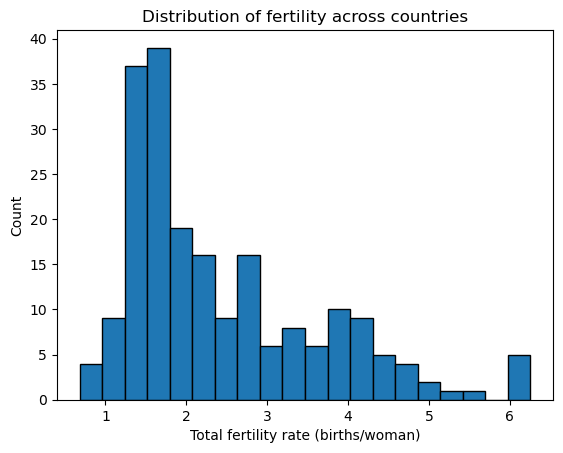

In [79]:
y.plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel('Total fertility rate (births/woman)')
plt.ylabel('Count')
plt.title('Distribution of fertility across countries')
plt.show()


In [80]:
corrs = {}
for c in X.columns:
    valid = df[[c, TARGET]].dropna()
    if len(valid) >= 30:
        corrs[c] = valid[c].corr(valid[TARGET])
corrs = pd.Series(corrs).dropna().sort_values(key=lambda s: s.abs(), ascending=False)

top8 = corrs.head(8)
display(top8)  

pop_youth014_pct            0.944852
pop_age_dependency_pct      0.864839
pop_lifeexp_female_years   -0.831939
tech_internet_users_pct    -0.831749
pop_working_age_pct        -0.826221
hlth_stunting_u5_pct        0.806497
hlth_infant_mort_per_1k     0.778577
pop_lifeexp_male_years     -0.772775
dtype: float64

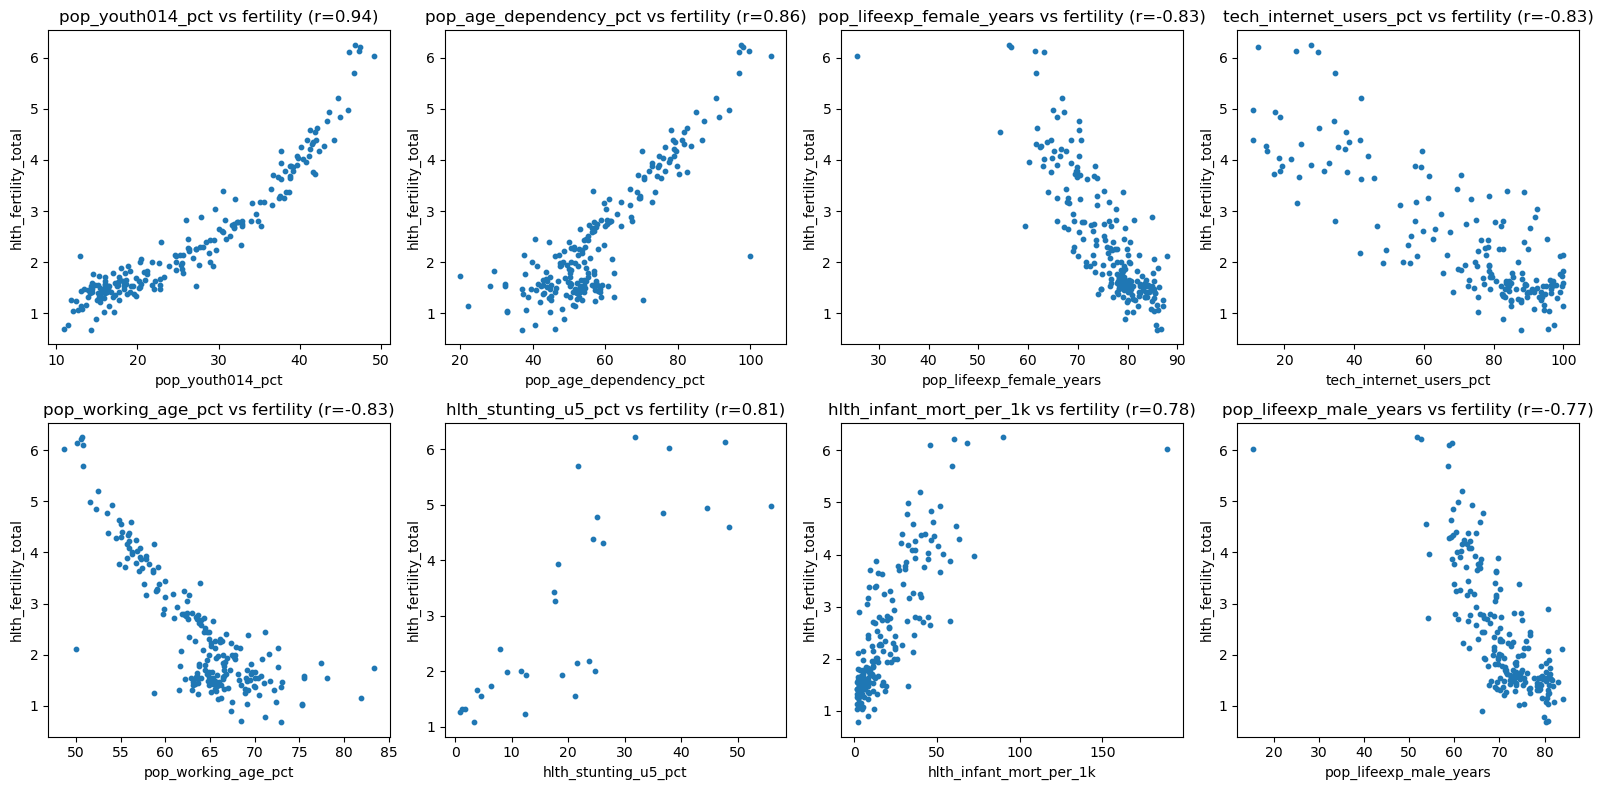

In [81]:
cols = top8.index.tolist()
n = len(cols)
rows = (n + 3)//4
plt.figure(figsize=(16, 4*rows))
for i, c in enumerate(cols, 1):
    ax = plt.subplot(rows, 4, i)
    valid = df[[c, TARGET]].dropna()
    ax.scatter(valid[c], valid[TARGET], s=10)
    ax.set_xlabel(c); ax.set_ylabel(TARGET)
    ax.set_title(f"{c} vs fertility (r={valid[c].corr(valid[TARGET]):.2f})")
plt.tight_layout(); plt.show()


In [82]:
ols_vars = [
    'edu_spend_gdp_pct',
    'edu_enroll_secondary_gross_pct',
    'edu_enroll_tertiary_gross_pct',
    'pop_urban_pct',
    'lead_parliament_women_pct',
    'pop_lifeexp_female_years'
]
ols_vars = [v for v in ols_vars if v in X.columns]


In [84]:
ols_df = df[ols_vars + [TARGET]].dropna()
X_ols = sm.add_constant(ols_df[ols_vars])
y_ols = ols_df[TARGET]
ols_model = sm.OLS(y_ols, X_ols).fit()
print(ols_model.summary())


                             OLS Regression Results                             
Dep. Variable:     hlth_fertility_total   R-squared:                       0.735
Model:                              OLS   Adj. R-squared:                  0.716
Method:                   Least Squares   F-statistic:                     39.29
Date:                  Thu, 16 Oct 2025   Prob (F-statistic):           1.64e-22
Time:                          23:09:47   Log-Likelihood:                -54.526
No. Observations:                    92   AIC:                             123.1
Df Residuals:                        85   BIC:                             140.7
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

### 3. Train Model

In [85]:
X = X.copy()
y = y.copy()

mask = y.notna()
X, y = X[mask], y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123
)


In [87]:
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

lin = Pipeline([
    ('prep', num_pipe),
    ('model', LinearRegression())
])

lasso = Pipeline([
    ('prep', num_pipe),
    ('model', Lasso(alpha=0.05, max_iter=10000, random_state=123))
])


In [88]:
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

lasso.fit(X_train, y_train)
pred_las = lasso.predict(X_test)

res = pd.DataFrame([
    {'model':'Linear', 'R2': r2_score(y_test, pred_lin), 'RMSE': mean_squared_error(y_test, pred_lin, squared=False)},
    {'model':'Lasso (α=0.05)', 'R2': r2_score(y_test, pred_las), 'RMSE': mean_squared_error(y_test, pred_las, squared=False)}
])
res


TypeError: got an unexpected keyword argument 'squared'